# Ethical Image Content Moderation Pipeline

This notebook implements a step-by-step pipeline for detecting and censoring harmful (NSFW/nudity/explicit) regions in user-uploaded images using open-source models. It uses NudeNet for region detection, Hugging Face models for confirmation, and Stable Diffusion for inpainting.

**Key Steps:**
1. Upload an image.
2. Detect harmful regions.
3. Outline and mask them.
4. Inpaint with safe content.

**Note:** Run on GPU (Runtime > Change runtime type > T4 GPU). This is for content safety/moderation only—not for bypassing restrictions. Models may have false positives/negatives; use ethically.

In [ ]:
!nvidia-smi

Thu Jan  1 17:54:15 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Install Dependencies

Install all required libraries in one go. This includes NudeNet (via PyPI), Diffusers for inpainting, Transformers for HF models, and Gradio for interactivity.

In [ ]:
!pip install nudenet diffusers transformers accelerate torch opencv-python numpy pillow gradio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.5 MB/s eta 0:00:00


## Imports and Model Loading

We use:
- NudeNet for per-region detection.
- Falconsai/nsfw_image_detection and AdamCodd/vit-base-nsfw-detector for ensemble NSFW classification.
- stabilityai/stable-diffusion-2-inpainting for inpainting.

In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageDraw
import torch
from diffusers import StableDiffusionInpaintPipeline
from transformers import pipeline
from nudenet import NudeDetector
import gradio as gr

# Load NudeNet detector
nude_detector = NudeDetector()

# Load HF NSFW classifiers
nsfw_classifier1 = pipeline("image-classification", model="Falconsai/nsfw_image_detection")
nsfw_classifier2 = pipeline("image-classification", model="AdamCodd/vit-base-nsfw-detector")

# Load Stable Diffusion Inpainting (try stabilityai, fallback to runwayml if error)
from diffusers.utils import logging
logging.set_verbosity_error()  # Suppress warnings

try:
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        torch_dtype=torch.float16,
        safety_checker=None  # Disable to avoid black NSFW blocks
    )
except Exception:
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "runwayml/stable-diffusion-inpainting",
        torch_dtype=torch.float16,
        safety_checker=None  # Disable to avoid black NSFW blocks
    )
pipe.enable_attention_slicing()
pipe.to("cuda")

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/344M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

Device set to use cuda:0


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
`torch_dtype` is deprecated! Use `dtype` instead!


StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.36.0",
  "_name_or_path": "runwayml/stable-diffusion-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

## Function Definitions

Define functions for:
- Detecting harmful regions with NudeNet and confirming with HF models.
- Generating a binary mask (dilated for better coverage).
- Outlining harmful regions on the original image.
- Inpainting the masked regions with a safe prompt.

Harmful classes from NudeNet: FEMALE_BREAST_EXPOSED, FEMALE_GENITALIA_EXPOSED, etc.

If no harmful content, return original.

In [ ]:
def detect_harmful_regions(image_path):
    """Detect harmful regions using NudeNet and confirm with HF models."""
    # NudeNet detection
    detections = nude_detector.detect(image_path)
    harmful_detections = [d for d in detections if d['class'] in [
        'FEMALE_BREAST_EXPOSED', 'FEMALE_GENITALIA_EXPOSED', 'MALE_GENITALIA_EXPOSED',
        'ANUS_EXPOSED', 'BUTTOCKS_EXPOSED', 'MALE_BREAST_EXPOSED'  # Adjust if male breast not harmful
    ]]

    # Confirm with HF ensemble (extract 'nsfw' score properly)
    img = Image.open(image_path)
    results1 = nsfw_classifier1(img)
    score1 = next((item['score'] for item in results1 if item['label'] == 'nsfw'), 0)
    results2 = nsfw_classifier2(img)
    score2 = next((item['score'] for item in results2 if item['label'] == 'nsfw'), 0)
    is_nsfw = (score1 > 0.7 or score2 > 0.7) and bool(harmful_detections)

    return harmful_detections if is_nsfw else []

def generate_mask(image_path, detections, dilate=20):
    """Generate dilated binary mask for harmful regions, merging for coherence."""
    img = cv2.imread(image_path)
    height, width = img.shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)

    if not detections:
        return Image.fromarray(mask).convert("L")

    # Find overall bounding box for all detections
    min_x = width
    min_y = height
    max_x = 0
    max_y = 0
    has_lower = False
    for det in detections:
        x, y, w, h = det['box']
        min_x = min(min_x, x)
        min_y = min(min_y, y)
        max_x = max(max_x, x + w)
        max_y = max(max_y, y + h)
        if any(c in det['class'] for c in ['GENITALIA', 'ANUS', 'BUTTOCKS']):
            has_lower = True

    # # Expand bounds for merging (add padding, more for lower body)
    # pad = 50 if has_lower else 30
    # min_x = max(0, min_x - pad)
    # min_y = max(0, min_y - pad)
    # max_x = min(width, max_x + pad)
    # max_y = min(height, max_y + pad)

    cv2.rectangle(mask, (min_x, min_y), (max_x, max_y), 255, -1)

    # Dilate the merged mask
    dilate_size = 30 if has_lower else dilate
    kernel = np.ones((dilate_size, dilate_size), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=2)

    return Image.fromarray(mask).convert("L")

def outline_harmful_regions(image_path, detections):
    """Display original with red outlines around harmful regions."""
    img = Image.open(image_path).copy()
    draw = ImageDraw.Draw(img, "RGBA")

    for det in detections:
        x, y, w, h = det['box']
        draw.rectangle((x, y, x + w, y + h), outline=(255, 0, 0, 255), width=5)

    return img

def generate_prompt(detections):
    """Generate dynamic safe prompt based on detected classes."""
    base_prompt = "photorealistic high-resolution image, detailed clothing textures (full coverage:1.2), seamless blend, no exposed skin, high detail, realistic lighting"
    negative_prompt = "nsfw, nude, explicit, exposed skin, exposed genitalia, exposed breasts, blur, low quality, artifacts, deformed, ugly, naked, partial clothing"

    # Tailor based on harmful classes for unified outfit
    has_breasts = any('BREAST' in d['class'] for d in detections)
    has_genitalia = any('GENITALIA' in d['class'] or 'ANUS' in d['class'] for d in detections)
    has_buttocks = any('BUTTOCKS' in d['class'] for d in detections)

    if has_breasts or has_genitalia or has_buttocks:
        subject = "woman" if has_breasts else "person"
        if has_breasts and (has_genitalia or has_buttocks):
            base_prompt += f", {subject} fully clothed in a modest long dress (covering chest, torso, lower body, and private areas completely:1.4), elegant cotton fabric, detailed patterns, neutral colors like blue or gray"
        elif has_genitalia or has_buttocks:
            base_prompt += f", {subject} wearing long pants (covering lower body, genitalia, and buttocks fully:1.3), realistic denim or cotton material, casual style, seamless fit"
        elif has_breasts:
            base_prompt += f", {subject} wearing a fitted blouse (covering chest completely:1.2), soft fabric, modest design, detailed buttons and seams"

    return base_prompt, negative_prompt

def inpaint_safe(image_path, mask, detections):
    """Inpaint masked regions with safe prompt using Stable Diffusion."""
    orig_img = Image.open(image_path).convert("RGB")
    orig_size = orig_img.size

    # Aspect-preserving resize and pad to 512x512
    ratio = min(512 / orig_size[0], 512 / orig_size[1])
    new_size = (int(orig_size[0] * ratio), int(orig_size[1] * ratio))
    img = orig_img.resize(new_size, Image.LANCZOS)
    padded_img = Image.new("RGB", (512, 512), (0, 0, 0))
    padded_img.paste(img, ((512 - new_size[0]) // 2, (512 - new_size[1]) // 2))

    mask = mask.resize(new_size, Image.NEAREST)
    padded_mask = Image.new("L", (512, 512), 0)
    padded_mask.paste(mask, ((512 - new_size[0]) // 2, (512 - new_size[1]) // 2))

    # Dynamic safe prompt
    prompt, negative_prompt = generate_prompt(detections)

    # Inpaint
    censored = pipe(
        prompt=prompt,
        image=padded_img,
        mask_image=padded_mask,
        num_inference_steps=60,  # Balanced for quality and speed
        strength=0.9,  # Adjusted for better coverage without blur
        guidance_scale=9.5,
        negative_prompt=negative_prompt
    ).images[0]

    # Crop back to original aspect and resize
    censored = censored.crop(((512 - new_size[0]) // 2, (512 - new_size[1]) // 2, (512 + new_size[0]) // 2, (512 + new_size[1]) // 2))
    censored = censored.resize(orig_size, Image.LANCZOS)

    return censored

def process_image(image_path):
    """Main pipeline: Detect, mask, outline, inpaint."""
    detections = detect_harmful_regions(image_path)
    if not detections:
        original = Image.open(image_path)
        return original, original, None, original  # Mask as None

    mask = generate_mask(image_path, detections)
    outlined = outline_harmful_regions(image_path, detections)
    censored = inpaint_safe(image_path, mask, detections)  # Pass detections

    return Image.open(image_path), outlined, mask, censored

  0%|          | 0/54 [00:00<?, ?it/s]

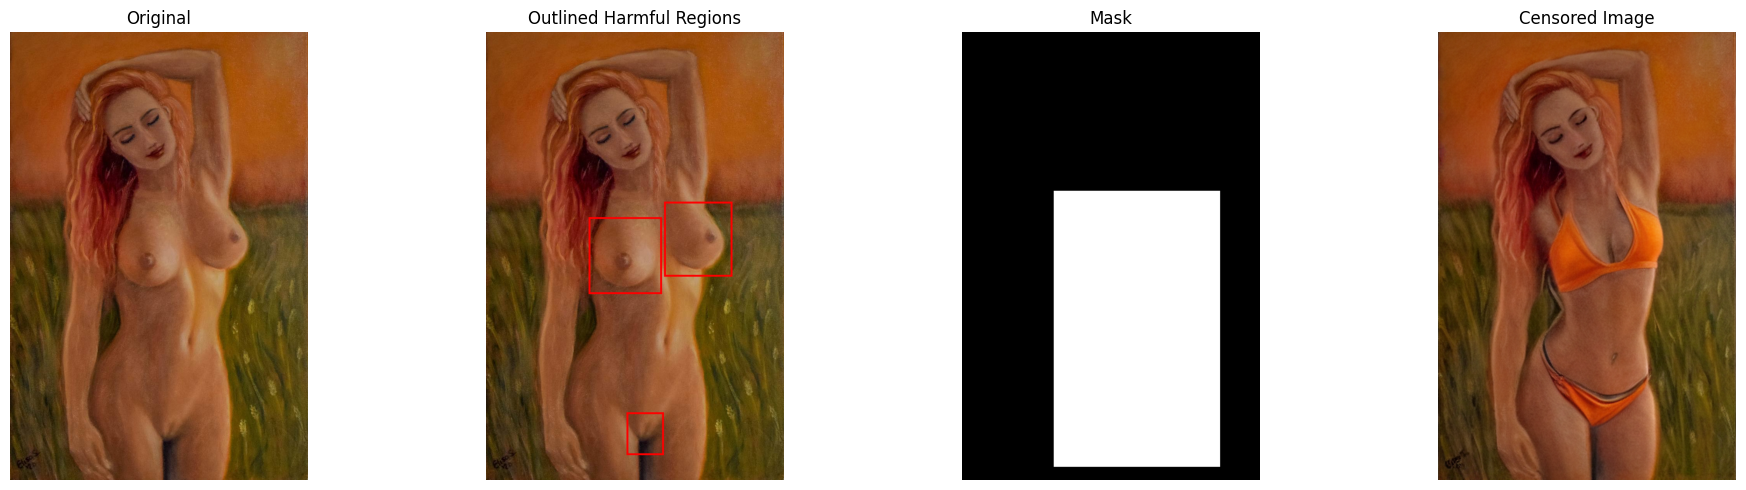

In [ ]:
import matplotlib.pyplot as plt

# Define the input image path (assume uploaded to Colab, e.g., via files.upload())
image_path = "/content/nsfw.jpg"  # Replace with your actual temp path in Colab storage

# Process the image
original, outlined, mask, censored = process_image(image_path)
if mask is None:
    mask = Image.new("L", original.size, 0)  # Blank mask if none

# Convert mask to RGB for consistent display (if it's grayscale)
if mask.mode == 'L':
    mask = mask.convert('RGB')

# Display images side-by-side for intuitive comparison
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(original)
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(outlined)
axs[1].set_title("Outlined Harmful Regions")
axs[1].axis('off')

axs[2].imshow(mask)
axs[2].set_title("Mask")
axs[2].axis('off')

axs[3].imshow(censored)
axs[3].set_title("Censored Image")
axs[3].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def detect_harmful_regions(image_path):
    """Detect harmful regions using NudeNet and confirm with HF models."""
    # NudeNet detection
    detections = nude_detector.detect(image_path)
    harmful_detections = [d for d in detections if d['class'] in [
        'FEMALE_BREAST_EXPOSED', 'FEMALE_GENITALIA_EXPOSED', 'MALE_GENITALIA_EXPOSED',
        'ANUS_EXPOSED', 'BUTTOCKS_EXPOSED', 'MALE_BREAST_EXPOSED'  # Adjust if male breast not harmful
    ]]

    # Confirm with HF ensemble (extract 'nsfw' score properly)
    img = Image.open(image_path)
    results1 = nsfw_classifier1(img)
    score1 = next((item['score'] for item in results1 if item['label'] == 'nsfw'), 0)
    results2 = nsfw_classifier2(img)
    score2 = next((item['score'] for item in results2 if item['label'] == 'nsfw'), 0)
    is_nsfw = (score1 > 0.7 or score2 > 0.7) and bool(harmful_detections)

    return harmful_detections if is_nsfw else []

def generate_uncombined_mask(image_path, detections, dilate=20):
    """Generate dilated binary mask for individual harmful regions without merging."""
    img = cv2.imread(image_path)
    height, width = img.shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)

    if not detections:
        return Image.fromarray(mask).convert("L")

    has_lower = any(c in det['class'] for det in detections for c in ['GENITALIA', 'ANUS', 'BUTTOCKS'])
    dilate_size = 30 if has_lower else dilate
    kernel = np.ones((dilate_size, dilate_size), np.uint8)

    for det in detections:
        x, y, w, h = det['box']
        # Draw individual rectangle
        individual_mask = np.zeros((height, width), dtype=np.uint8)
        cv2.rectangle(individual_mask, (x, y), (x + w, y + h), 255, -1)
        # Dilate individually
        individual_mask = cv2.dilate(individual_mask, kernel, iterations=2 if has_lower else 1)
        # Combine into main mask (union)
        mask = cv2.bitwise_or(mask, individual_mask)

    return Image.fromarray(mask).convert("L")

def generate_mask(image_path, detections, dilate=20):
    """Generate dilated binary mask for harmful regions, merging for coherence."""
    img = cv2.imread(image_path)
    height, width = img.shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)

    if not detections:
        return Image.fromarray(mask).convert("L")

    # Find overall bounding box for all detections
    min_x = width
    min_y = height
    max_x = 0
    max_y = 0
    has_lower = False
    for det in detections:
        x, y, w, h = det['box']
        min_x = min(min_x, x)
        min_y = min(min_y, y)
        max_x = max(max_x, x + w)
        max_y = max(max_y, y + h)
        if any(c in det['class'] for c in ['GENITALIA', 'ANUS', 'BUTTOCKS']):
            has_lower = True

    # # Expand bounds for merging (add padding, more for lower body)
    # pad = 50 if has_lower else 30
    # min_x = max(0, min_x - pad)
    # min_y = max(0, min_y - pad)
    # max_x = min(width, max_x + pad)
    # max_y = min(height, max_y + pad)

    cv2.rectangle(mask, (min_x, min_y), (max_x, max_y), 255, -1)

    # Dilate the merged mask
    dilate_size = 30 if has_lower else dilate
    kernel = np.ones((dilate_size, dilate_size), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=2)

    return Image.fromarray(mask).convert("L")

def outline_harmful_regions(image_path, detections):
    """Display original with red outlines around harmful regions."""
    img = Image.open(image_path).copy()
    draw = ImageDraw.Draw(img, "RGBA")

    for det in detections:
        x, y, w, h = det['box']
        draw.rectangle((x, y, x + w, y + h), outline=(255, 0, 0, 255), width=5)

    return img

def generate_prompt(detections):
    """Generate dynamic safe prompt based on detected classes."""
    base_prompt = "photorealistic high-resolution image, detailed clothing textures (full coverage:1.2), seamless blend, no exposed skin, high detail, realistic lighting"
    negative_prompt = "nsfw, nude, explicit, exposed skin, exposed genitalia, exposed breasts, blur, low quality, artifacts, deformed, ugly, naked, partial clothing"

    # Tailor based on harmful classes for unified outfit
    has_breasts = any('BREAST' in d['class'] for d in detections)
    has_genitalia = any('GENITALIA' in d['class'] or 'ANUS' in d['class'] for d in detections)
    has_buttocks = any('BUTTOCKS' in d['class'] for d in detections)

    if has_breasts or has_genitalia or has_buttocks:
        subject = "woman" if has_breasts else "person"
        if has_breasts and (has_genitalia or has_buttocks):
            base_prompt += f", {subject} fully clothed in a modest long dress (covering chest, torso, lower body, and private areas completely:1.4), elegant cotton fabric, detailed patterns, neutral colors like blue or gray"
        elif has_genitalia or has_buttocks:
            base_prompt += f", {subject} wearing long pants (covering lower body, genitalia, and buttocks fully:1.3), realistic denim or cotton material, casual style, seamless fit"
        elif has_breasts:
            base_prompt += f", {subject} wearing a fitted blouse (covering chest completely:1.2), soft fabric, modest design, detailed buttons and seams"

    return base_prompt, negative_prompt

def inpaint_safe(image_path, mask, detections):
    """Inpaint masked regions with safe prompt using Stable Diffusion."""
    orig_img = Image.open(image_path).convert("RGB")
    orig_size = orig_img.size

    # Aspect-preserving resize and pad to 512x512
    ratio = min(512 / orig_size[0], 512 / orig_size[1])
    new_size = (int(orig_size[0] * ratio), int(orig_size[1] * ratio))
    img = orig_img.resize(new_size, Image.LANCZOS)
    padded_img = Image.new("RGB", (512, 512), (0, 0, 0))
    padded_img.paste(img, ((512 - new_size[0]) // 2, (512 - new_size[1]) // 2))

    mask = mask.resize(new_size, Image.NEAREST)
    padded_mask = Image.new("L", (512, 512), 0)
    padded_mask.paste(mask, ((512 - new_size[0]) // 2, (512 - new_size[1]) // 2))

    # Dynamic safe prompt
    prompt, negative_prompt = generate_prompt(detections)

    # Inpaint
    censored = pipe(
        prompt=prompt,
        image=padded_img,
        mask_image=padded_mask,
        num_inference_steps=60,  # Balanced for quality and speed
        strength=0.9,  # Adjusted for better coverage without blur
        guidance_scale=9.5,
        negative_prompt=negative_prompt
    ).images[0]

    # Crop back to original aspect and resize
    censored = censored.crop(((512 - new_size[0]) // 2, (512 - new_size[1]) // 2, (512 + new_size[0]) // 2, (512 + new_size[1]) // 2))
    censored = censored.resize(orig_size, Image.LANCZOS)

    return censored

def process_image(image_path):
    """Main pipeline: Detect, mask, outline, inpaint."""
    detections = detect_harmful_regions(image_path)
    if not detections:
        original = Image.open(image_path)
        return original, original, None, None, original  # Uncombined and combined masks as None

    uncombined_mask = generate_uncombined_mask(image_path, detections)
    combined_mask = generate_mask(image_path, detections)
    outlined = outline_harmful_regions(image_path, detections)
    censored = inpaint_safe(image_path, combined_mask, detections)  # Use combined mask for inpainting

    return Image.open(image_path), outlined, uncombined_mask, combined_mask, censored

  0%|          | 0/54 [00:00<?, ?it/s]

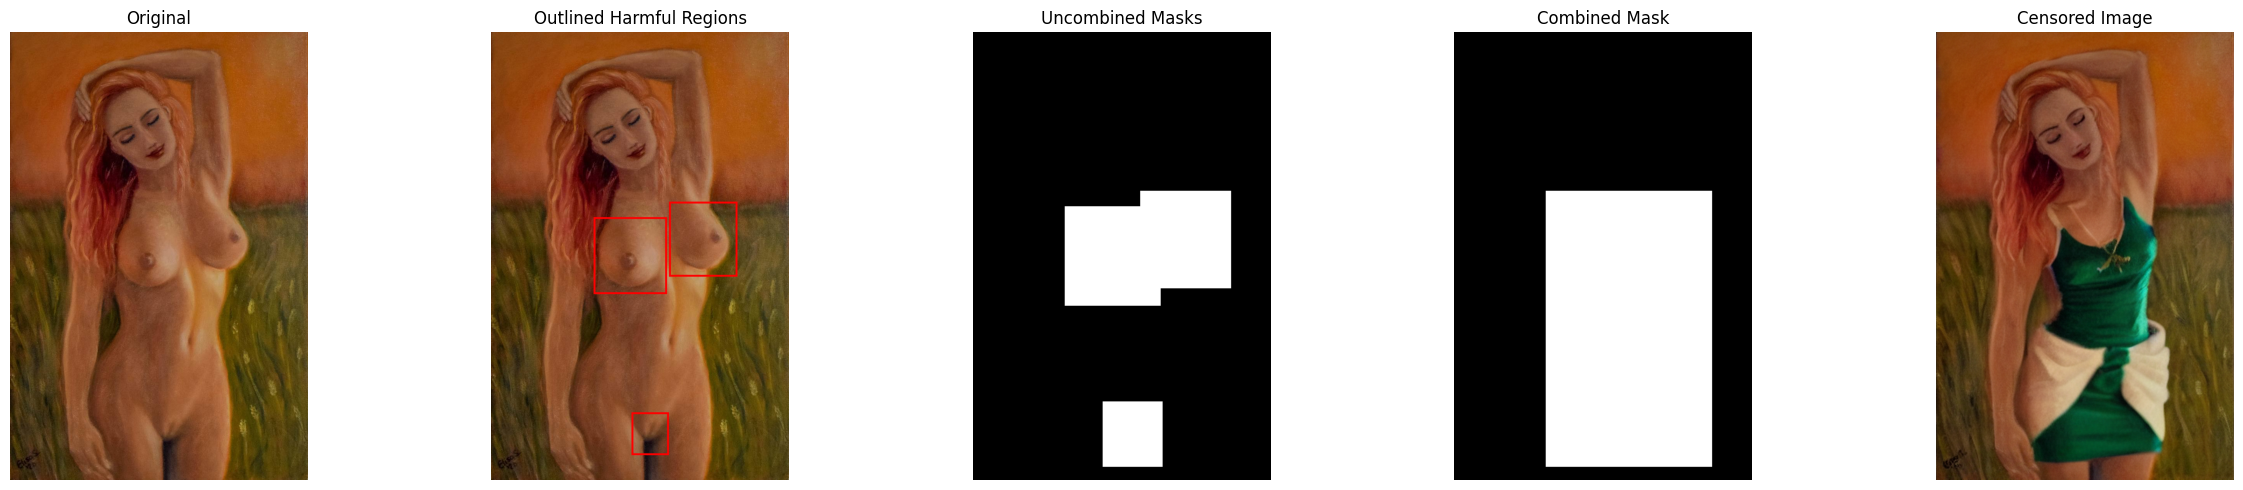

In [ ]:
import matplotlib.pyplot as plt

# Define the input image path (assume uploaded to Colab, e.g., via files.upload())
image_path = "/content/nsfw.jpg"  # Replace with your actual temp path in Colab storage

# Process the image
original, outlined, uncombined_mask, combined_mask, censored = process_image(image_path)
if uncombined_mask is None:
    uncombined_mask = Image.new("L", original.size, 0)  # Blank if none
if combined_mask is None:
    combined_mask = Image.new("L", original.size, 0)  # Blank if none

# Convert masks to RGB for consistent display (if grayscale)
if uncombined_mask.mode == 'L':
    uncombined_mask = uncombined_mask.convert('RGB')
if combined_mask.mode == 'L':
    combined_mask = combined_mask.convert('RGB')

# Display images side-by-side for intuitive comparison
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

axs[0].imshow(original)
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(outlined)
axs[1].set_title("Outlined Harmful Regions")
axs[1].axis('off')

axs[2].imshow(uncombined_mask)
axs[2].set_title("Uncombined Masks")
axs[2].axis('off')

axs[3].imshow(combined_mask)
axs[3].set_title("Combined Mask")
axs[3].axis('off')

axs[4].imshow(censored)
axs[4].set_title("Censored Image")
axs[4].axis('off')

plt.tight_layout()
plt.show()

## Interactive Interface

Use Gradio for easy upload and processing. Outputs: Original, Outlined, Mask, Censored.

In [ ]:
def gradio_process(image):
    """Gradio wrapper: Save temp image and process."""
    if image is None:
        return None, None, None, None

    image_path = "temp_image.jpg"
    image.save(image_path)

    original, outlined, mask, censored = process_image(image_path)
    if mask is None:
        mask = Image.new("L", original.size, 0)  # Blank mask if none
    return original, outlined, mask, censored

iface = gr.Interface(
    fn=gradio_process,
    inputs=gr.Image(type="pil", label="Upload Image"),
    outputs=[
        gr.Image(label="Original"),
        gr.Image(label="Outlined Harmful Regions"),
        gr.Image(label="Mask"),
        gr.Image(label="Censored Image")
    ],
    title="Image Content Moderator",
    description="Upload an image to detect and censor harmful content."
)

iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4b693f93a4d7d7617a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
